In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.Ml_methods import Ml_methods
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, cosine_distances
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage, fcluster

In [3]:
params_to_work_with = constants.ALL_PARAMS
ctx_outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB', 'H023_IN', 'H061_SE']
pd_outliers = ['PD028_YO', 'PD037_ES', 'PD044_TS', 'PD056_YK', 'PD004_KC']

In [4]:
def load_data(data_path, rois, outliers=[], data_cols=['subjects', 'Age', 'Gender']):
    subjects_raw_data = DataProcessor(
        data_path, rois, rois, data_cols).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(
        subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(
        analyzed_data, rois, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    return chosen_data


def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data

In [5]:
all_ctx_data_z_score= load_data(
    constants.PATH_TO_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers)

young_ctx_data_z_score, old_ctx_data_z_score = StatisticsWrapper.seperate_data_to_two_groups(
        all_ctx_data_z_score, 'Age', constants.AGE_THRESHOLD)
print(
    f'num young: {young_ctx_data_z_score.subjects.nunique()}, num old: {old_ctx_data_z_score.subjects.nunique()}')

pd_col_names = ['subjects', 'Age', 'Gender', 'Clinc_group']
all_pd_data_z_score= load_data(
    constants.PATH_TO_PD_CORTEX_all_params_z_score,
    constants.ROI_CORTEX,
    outliers=ctx_outliers,
    data_cols=pd_col_names)

ctl_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'CTL']
ctl_data_z_score = ctl_data_z_score[ctl_data_z_score.Age >= constants.AGE_THRESHOLD]
pd_data_z_score = all_pd_data_z_score[all_pd_data_z_score.Clinc_group == 'PD']

print(
    f'num pd: {pd_data_z_score.subjects.nunique()}, num ctl: {ctl_data_z_score.subjects.nunique()}')

num young: 16, num old: 14
num pd: 32, num ctl: 16


In [6]:
print(f'mean age of old subjects: {old_ctx_data_z_score.Age.mean()}. mean age of control subjects: {ctl_data_z_score.Age.mean()}')

mean age of old subjects: 67.42857142857143. mean age of control subjects: 70.9375


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


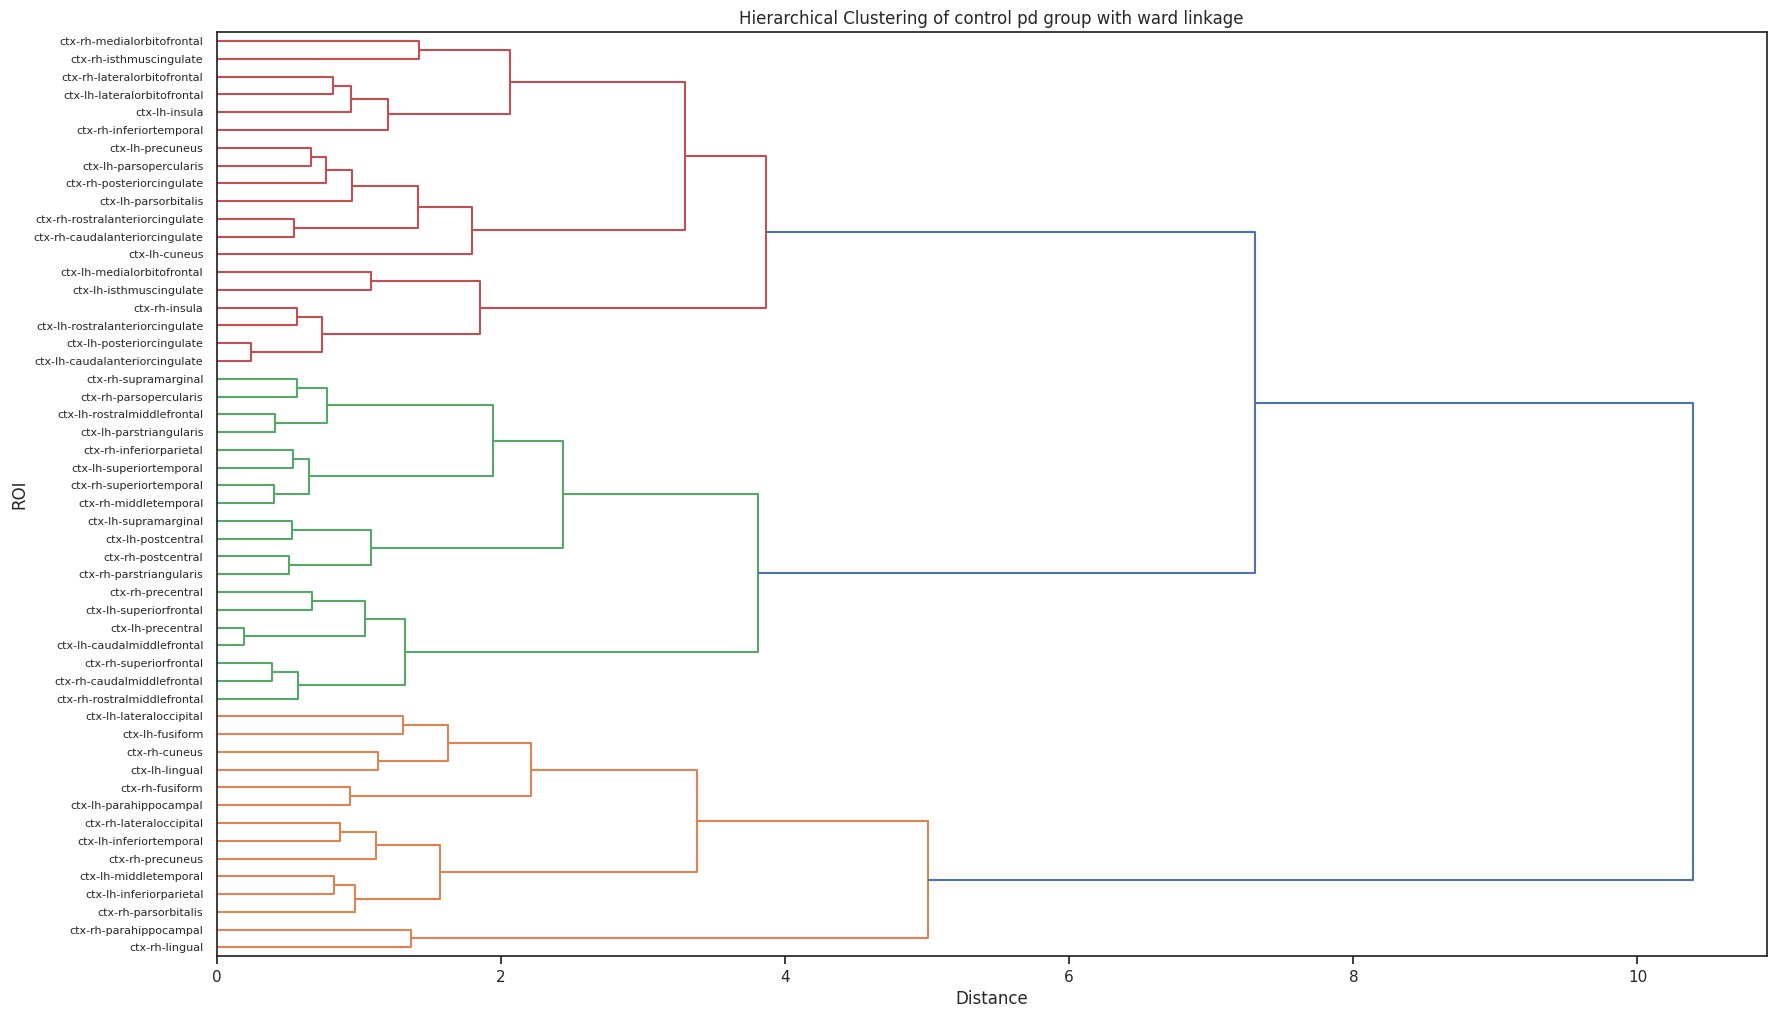

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


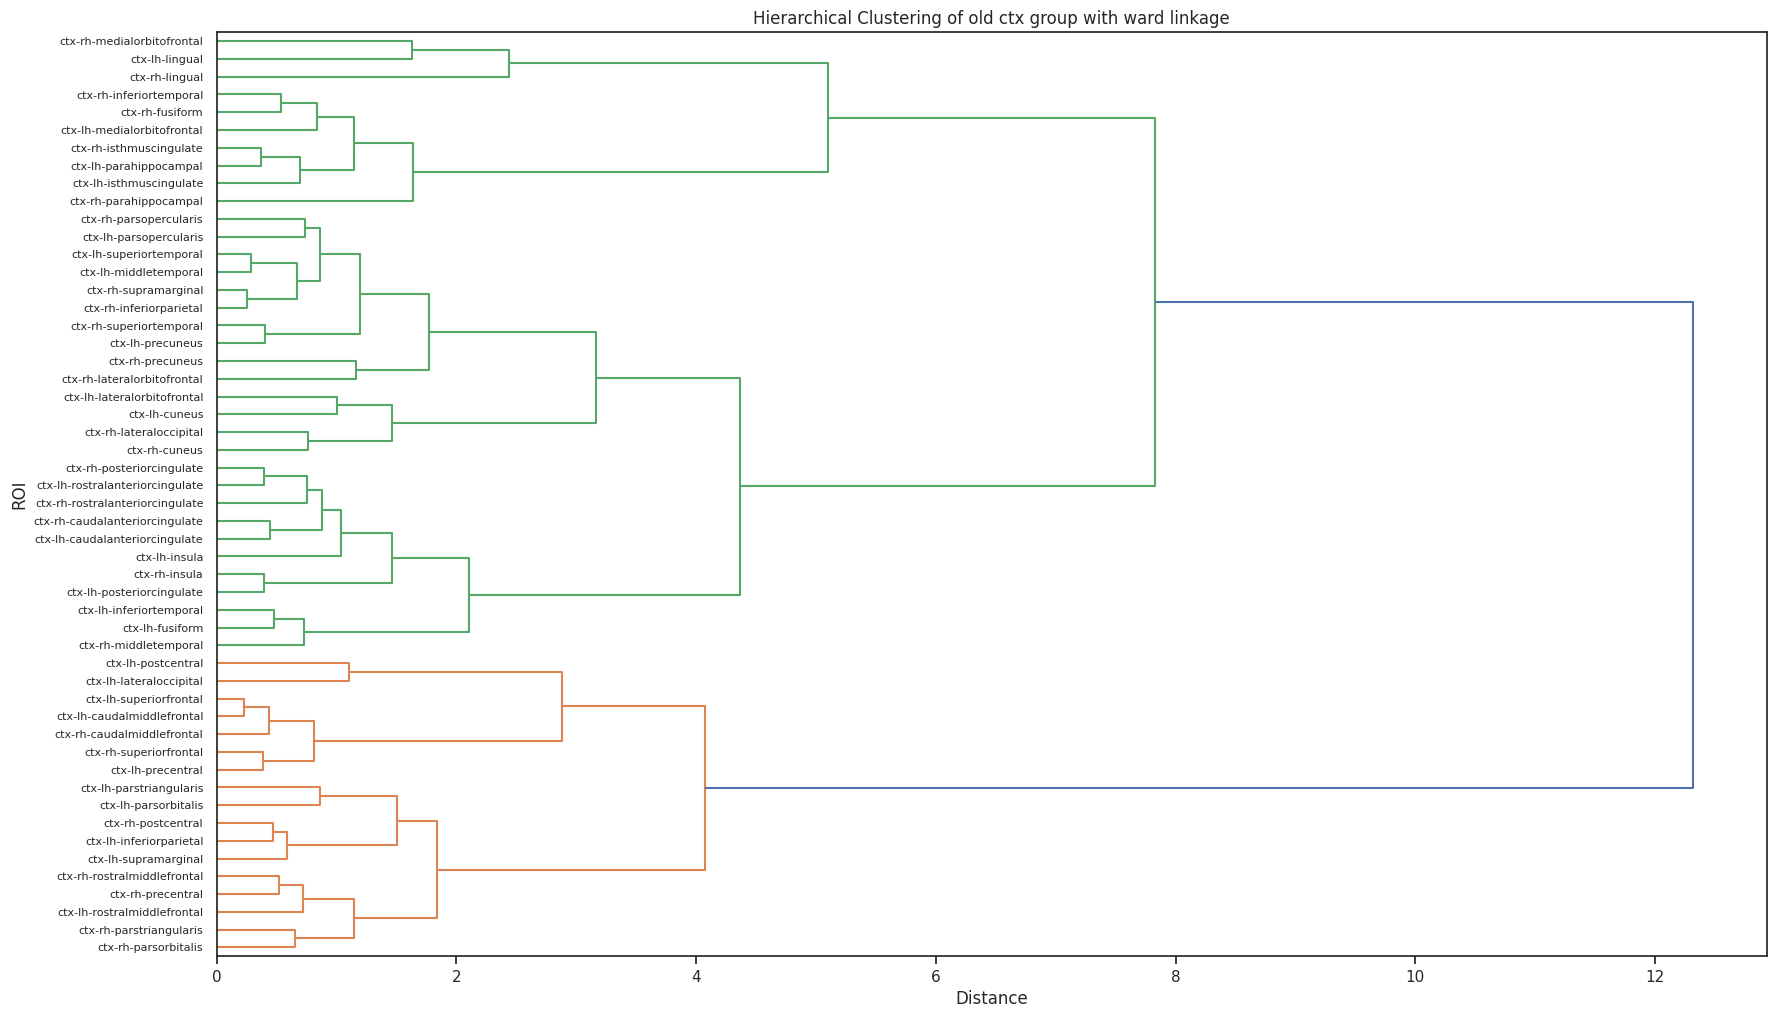

Adjusted Rand Index (ARI) of ward: 0.1731441833099075


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


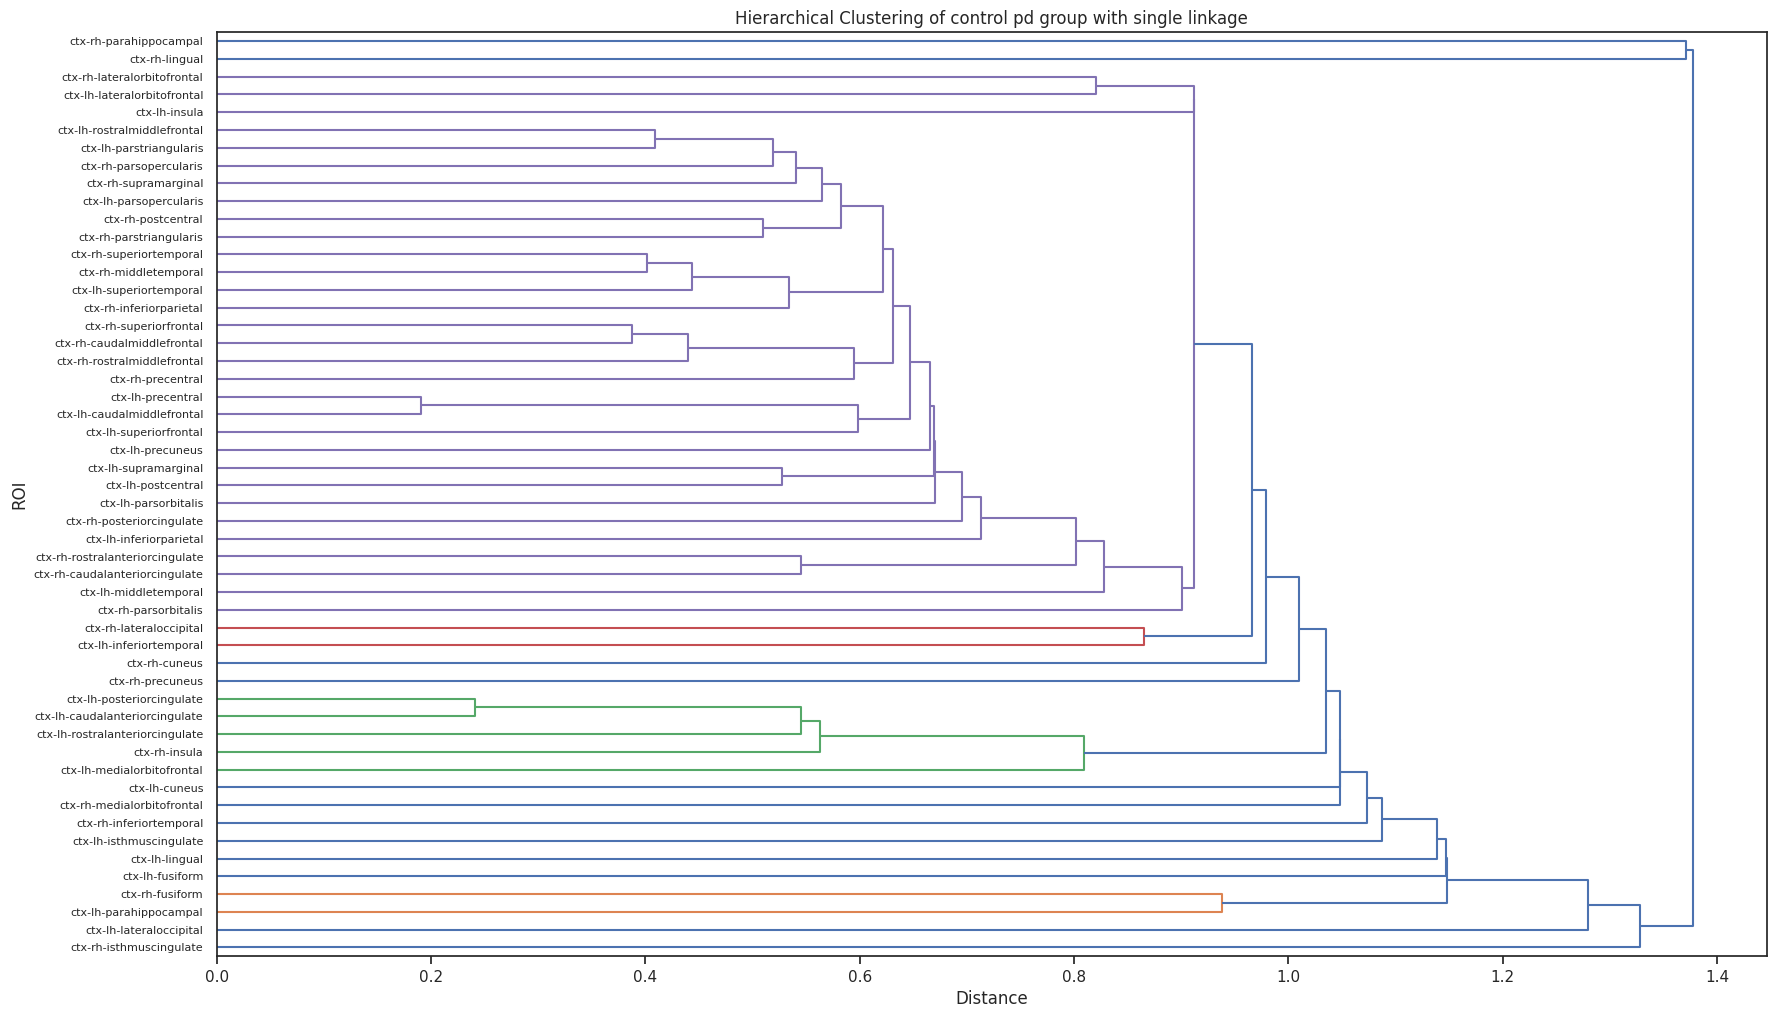

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


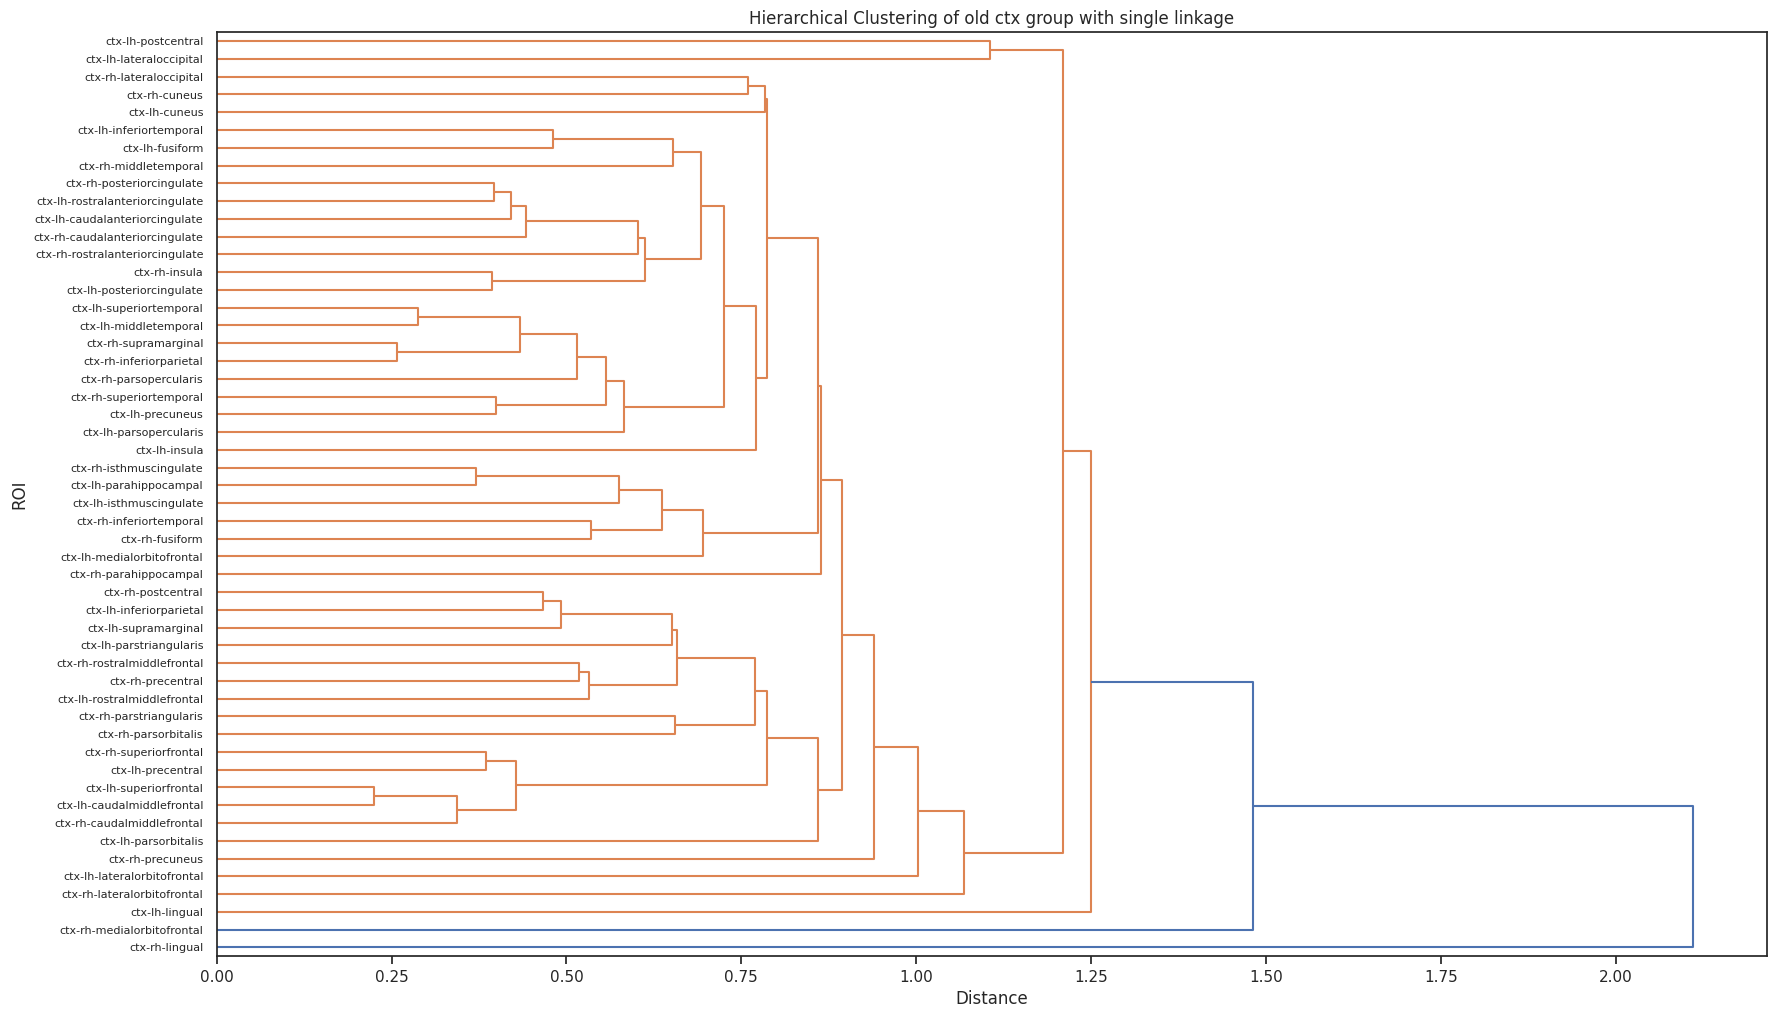

Adjusted Rand Index (ARI) of single: 0.47485148514851483


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


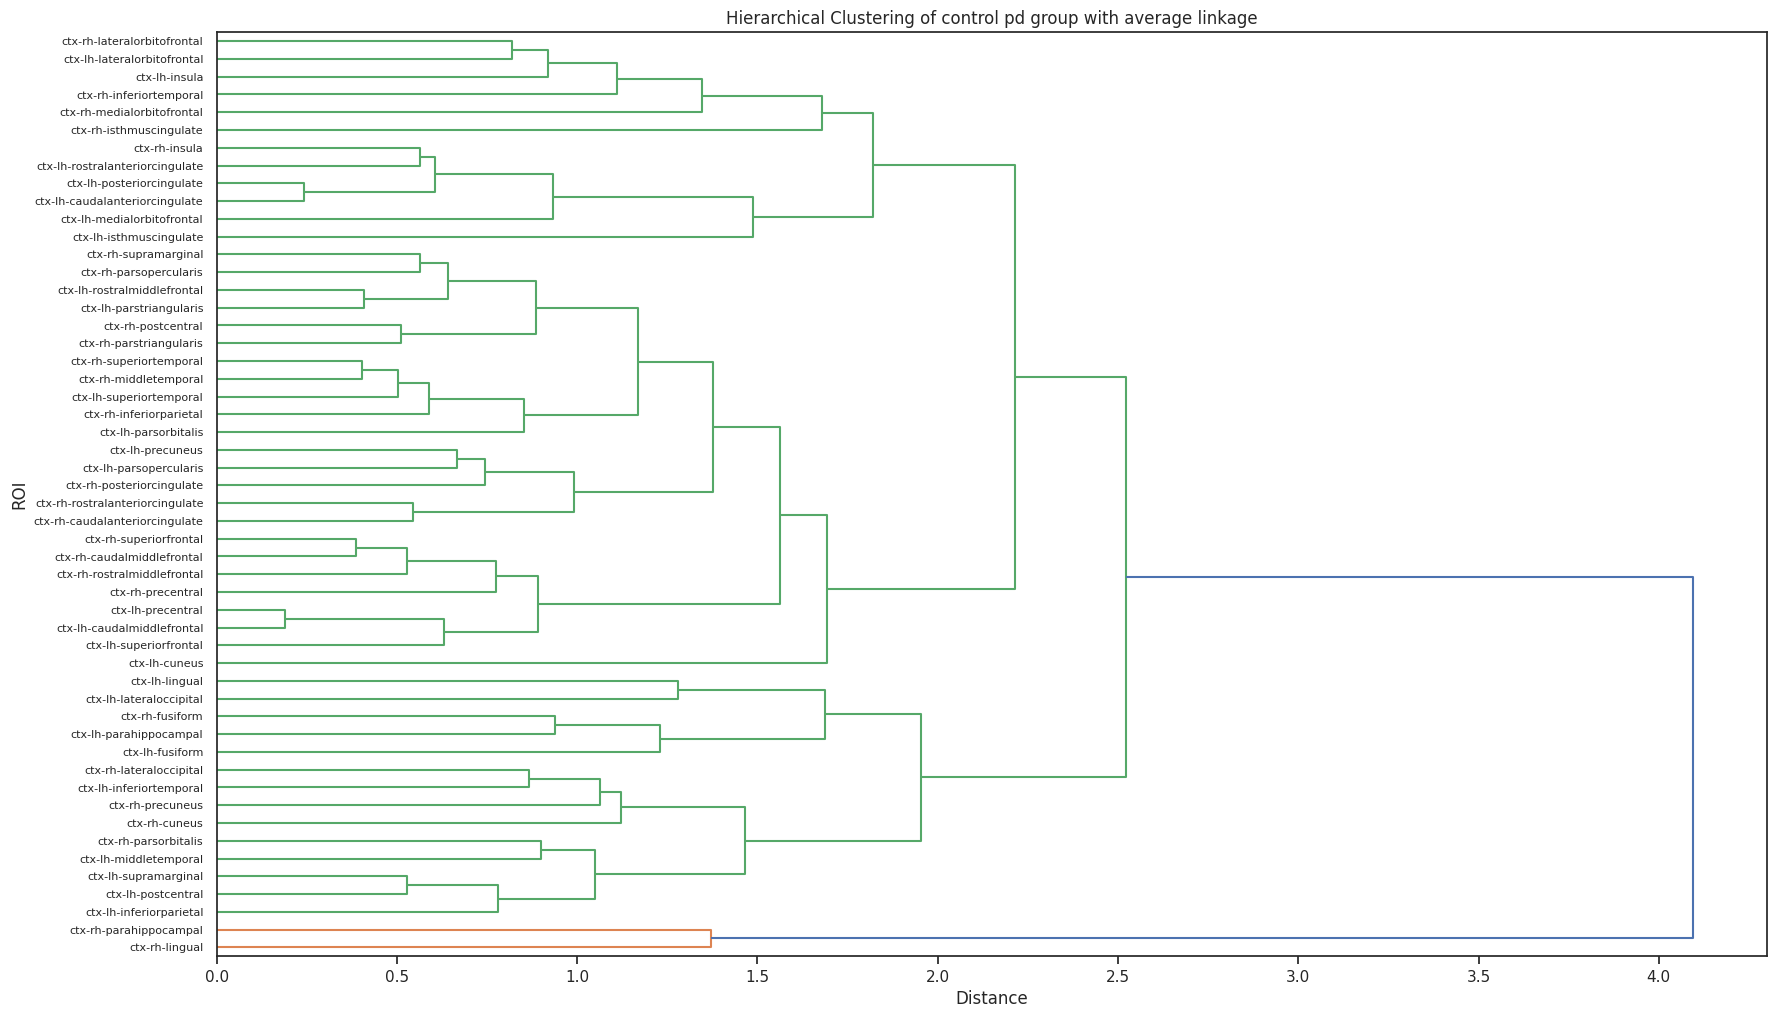

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


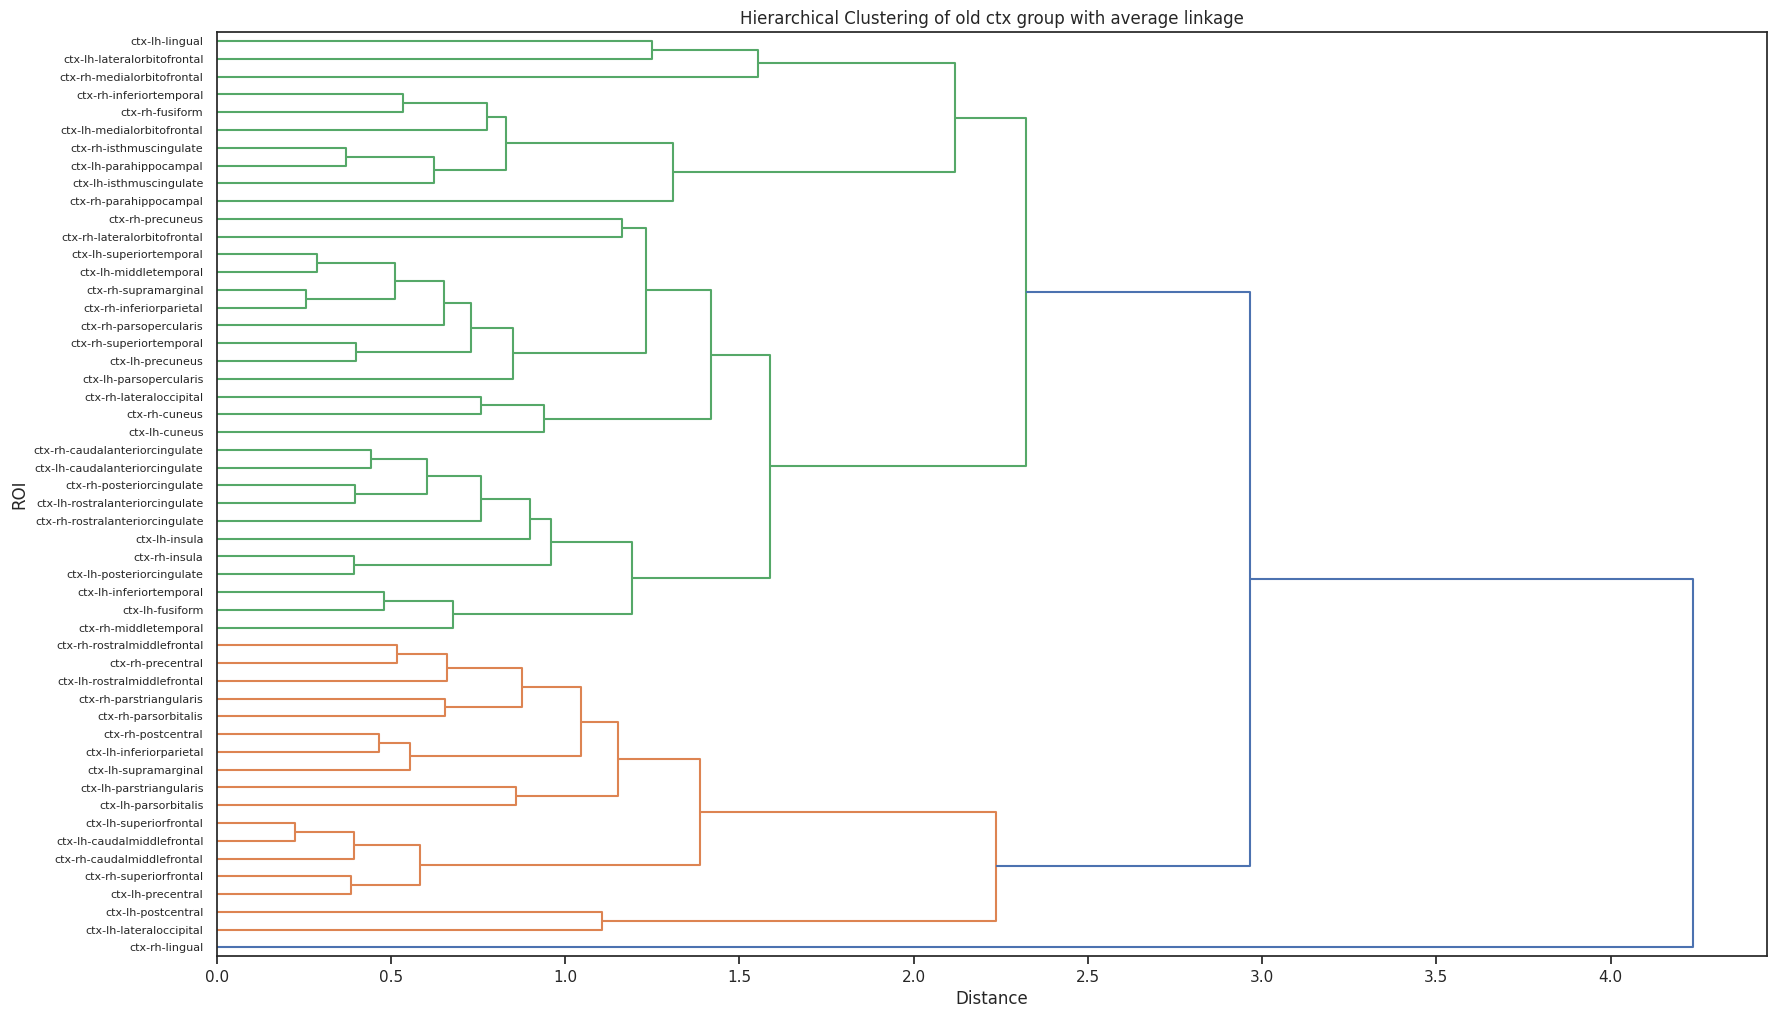

Adjusted Rand Index (ARI) of average: 0.025719724931038503


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


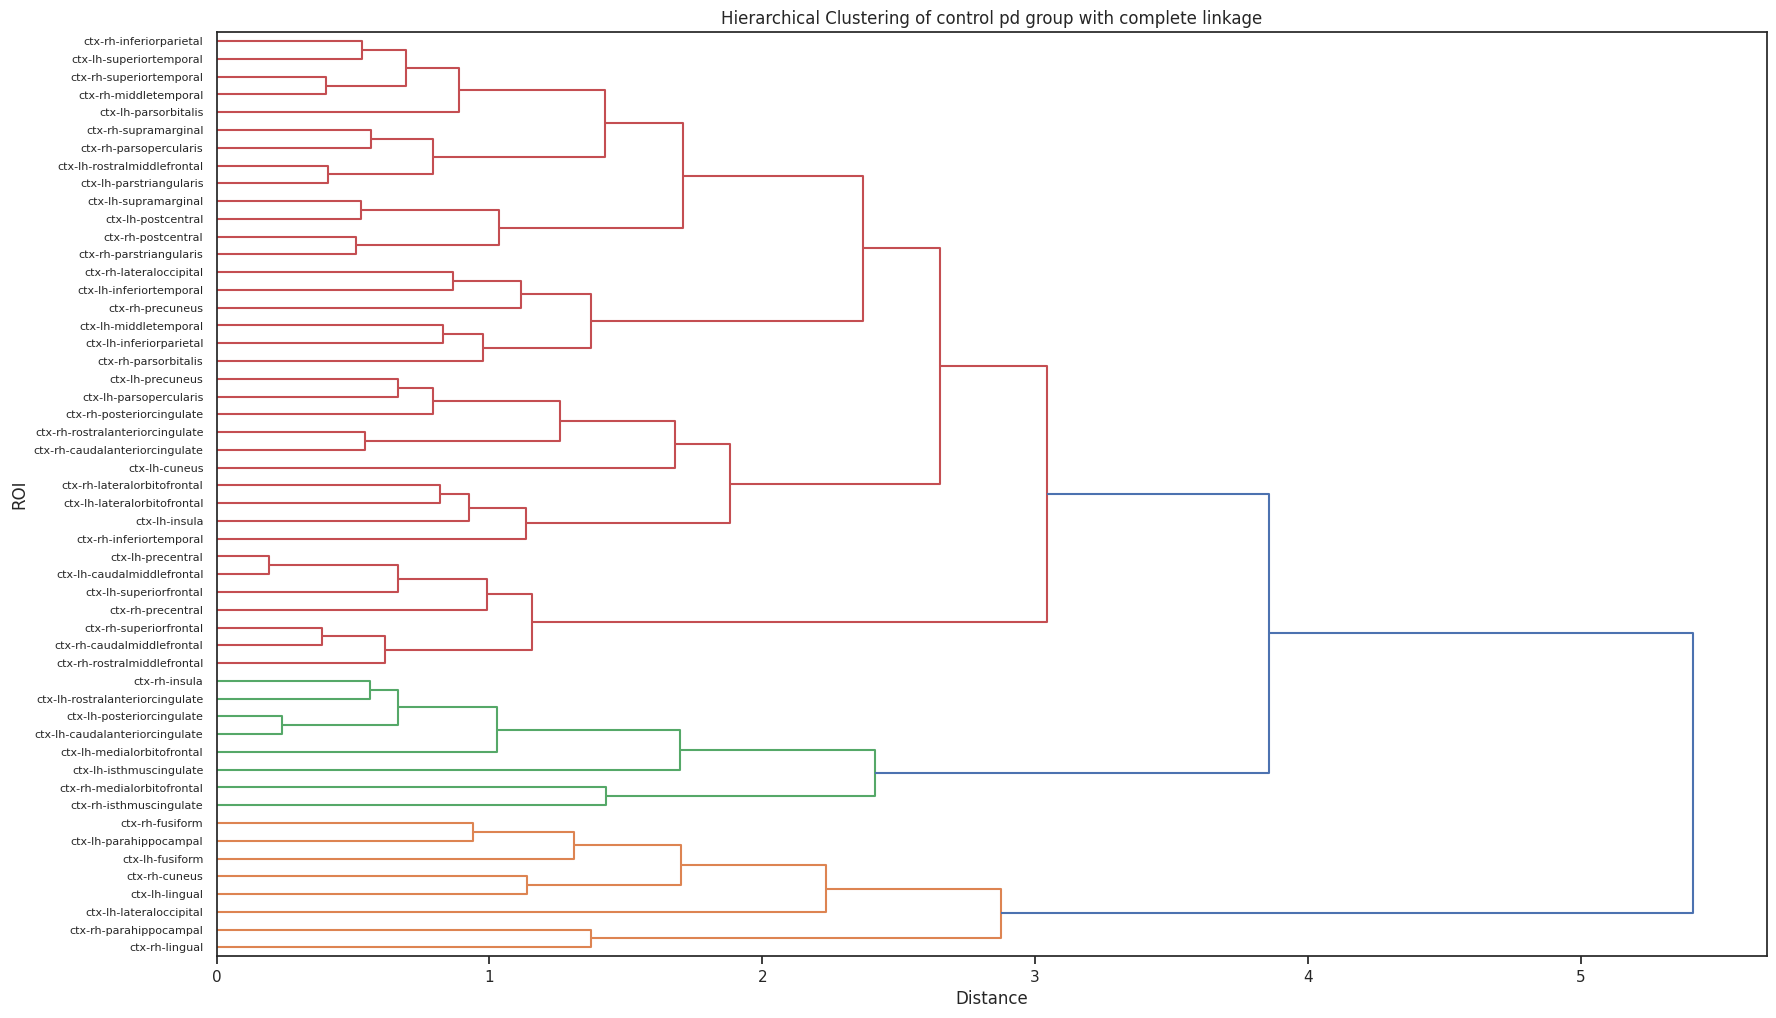

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:558: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


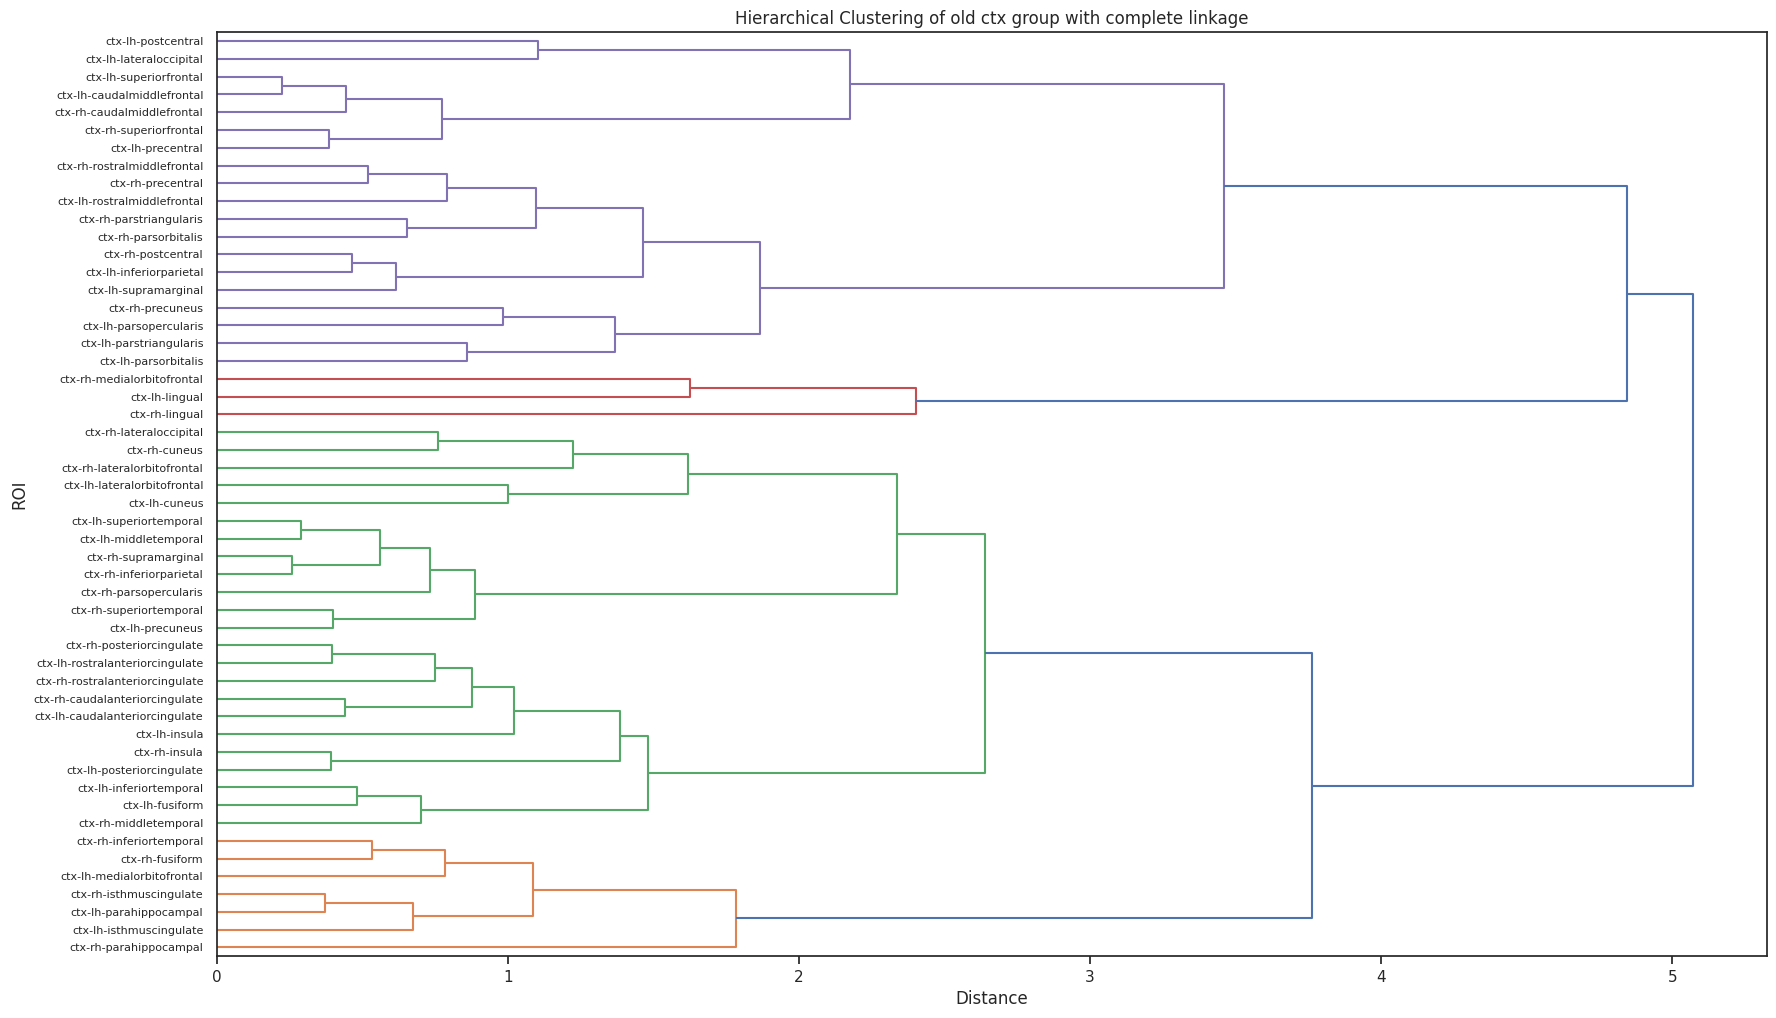

Adjusted Rand Index (ARI) of complete: 0.06899555591852291


In [10]:
%autoreload 2
linkage_res = {}

for linkage_method in ['ward', 'single', 'average', 'complete']:
    ctl_clustring_data =  StatisticsWrapper.hierarchical_clustering(ctl_data_z_score, params_to_work_with, linkage_method,
                                                                title="control pd")
    old_clustring_data =  StatisticsWrapper.hierarchical_clustering(old_ctx_data_z_score, params_to_work_with, linkage_method,
                                                                title="old ctx")
    
    ctl_labels = fcluster(ctl_clustring_data['clusters'], 3, criterion='maxclust')
    old_labels = fcluster(old_clustring_data['clusters'], 3, criterion='maxclust')
    
    ari = adjusted_rand_score(ctl_labels, old_labels)
    print(f'Adjusted Rand Index (ARI) of {linkage_method}: {ari}')


In [58]:
ari = adjusted_rand_score(linkage_res['average']['old_labels'], linkage_res['average']['ctl_labels'])
print(f'Adjusted Rand Index (ARI): {ari}')

Adjusted Rand Index (ARI): 0.025719724931038503
